In [1]:
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import numpy as np
from skimage import io, transform
import os
import cv2
import time

In [2]:
class Encoder(nn.Module):
    def __init__(self, nz):
        super().__init__()
        self.net = nn.Sequential(
            # add your network layers here
            # ...
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=8, stride=4, padding=2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=8, stride=4, padding=2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=8,stride=4, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=8, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.Flatten(),
            nn.Linear(in_features=256, out_features=nz)
        )

    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, nz):
        super().__init__()
        self.map = nn.Linear(in_features=nz, out_features=256)   # for initial Linear layer
        self.net = nn.Sequential(
            # add your network layers here
            # ...
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size=8, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=8, stride=4, padding=2),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=8, stride=4, padding=2),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=8, stride=4, padding=2),
        )

    def forward(self, x):
        #print(self.map(x))
        return self.net(self.map(x).reshape(-1, 256, 1, 1))

def kl_divergence(mu1, log_sigma1, mu2, log_sigma2):
  """Computes KL[p||q] between two Gaussians defined by [mu, log_sigma]."""
  return (log_sigma2 - log_sigma1) + (torch.exp(log_sigma1) ** 2 + (mu1 - mu2) ** 2) \
               / (2 * torch.exp(log_sigma2) ** 2) - 0.5


class VAE(nn.Module):
  def __init__(self, nz, beta=1.0):
    super().__init__()
    self.beta = beta          # factor trading off between two loss components
    self.encoder = Encoder(2 * nz)
    self.decoder = Decoder(nz)

    self.criterion = nn.MSELoss()

    self.mu = torch.ones([batch_size, nz])
    self.sigma = torch.zeros([batch_size, nz])

  def forward(self, x):
    # encode input into posterior distribution q(z | x)
    q = self.encoder(x)       # output of encoder (concatenated mean and log_sigma)

    self.mu = q[:, :nz]
    self.sigma = q[:, nz:]

    # sample latent variable z with reparametrization
    z = self.mu + self.sigma * torch.normal(0.0, 1.0, self.sigma.shape).to(device)     # batch of sampled embeddings

    # compute reconstruction
    reconstruction = self.decoder(z)   # decoder reconstruction from embedding

    return {'q': q, 
            'rec': reconstruction}

  def loss(self, target, output):
    # compute reconstruction loss
    rec_loss = self.criterion(output, target)

    # compute KL divergence loss
    #mu_mean = torch.mean(self.mu)
    #log_sigma_mean = torch.mean(torch.log(self.sigma))
    kl_loss = kl_divergence(self.mu, self.sigma, torch.zeros(self.mu.shape).to(device), torch.ones(self.sigma.shape).to(device))    
    # make sure that this is a scalar, not a vector / array
    #print(kl_loss)
    kl_loss = torch.mean(kl_loss)
    #print(kl_loss)
    

    # return weihgted objective
    return rec_loss + self.beta * kl_loss, \
           {'rec_loss': rec_loss, 'kl_loss': kl_loss}
    
  def reconstruct(self, x):
    """Use mean of posterior estimate for visualization reconstruction."""
    q = self.encoder(x)
    mean = q[:, :nz]
    reconstruction = self.decoder(mean) 
    return reconstruction


In [3]:
class TrainData(torch.utils.data.Dataset):
    def __init__(self, input_path, target_path):
        self.input_path = input_path
        self.input_names = os.listdir(self.input_path)
        self.target_path = target_path
        self.target_names = os.listdir(self.target_path)

    def __getitem__(self, index):
        # print(self.input_path)

        input_img = cv2.imread(input_path + self.input_names[index]) / 255
        target_img = cv2.imread(target_path + self.target_names[index]) / 255
        
        input_img = torch.from_numpy(input_img).float()
        target_img = torch.from_numpy(target_img).float()

        input_img = input_img.permute(2, 0, 1)
        target_img = target_img.permute(2, 0, 1)

        #input_img = transformations.ToTensor()(input_img)
        #target_img = transformations.ToTensor()(target_img)

        #return {"input": input_img, "target": target_img}
        return input_img, target_img
    
    def __len__(self):
        return len(self.input_names)


In [4]:
input_path = "../Data/input/"
target_path = "../Data/target/"

batch_size = 256

#nworkers = 4

data = TrainData(input_path = input_path, target_path = target_path)
dataloader = torch.utils.data.DataLoader(dataset = data, batch_size = batch_size, shuffle = True)

ed. time remaining: 143940.30 mins.
Epoch 52 finished (26.50%). time remaining: 423.31 mins.
Run Epoch 53
Epoch 53 finished (27.00%). time remaining: 420.05 mins.
Run Epoch 54
Epoch 54 finished (27.50%). time remaining: 417.05 mins.
Run Epoch 55
Iter 2200: Total Loss: 0.04630669206380844, Rec Loss: 0.04240527004003525, KL Loss: 0.026009466499090195
0.11% iteration finished. time remaining: 143653.06 mins.
Epoch 55 finished (28.00%). time remaining: 413.70 mins.
Run Epoch 56
Epoch 56 finished (28.50%). time remaining: 410.44 mins.
Run Epoch 57
Iter 2300: Total Loss: 0.046099044382572174, Rec Loss: 0.04238135740160942, KL Loss: 0.024784572422504425
0.12% iteration finished. time remaining: 143377.26 mins.
Epoch 57 finished (29.00%). time remaining: 407.53 mins.
Run Epoch 58
Epoch 58 finished (29.50%). time remaining: 404.52 mins.
Run Epoch 59
Epoch 59 finished (30.00%). time remaining: 401.52 mins.
Run Epoch 60
Iter 2400: Total Loss: 0.04411644861102104, Rec Loss: 0.04007716104388237, KL

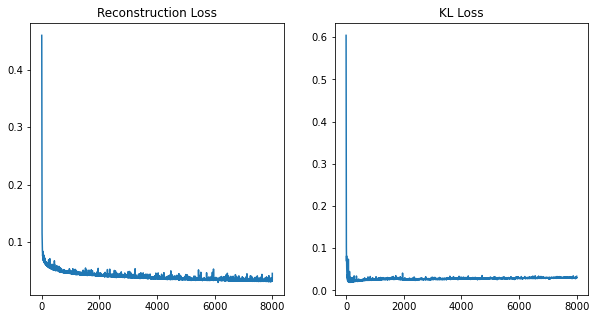

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data_size = len(data)

epoch_size = 200

beta = 0.15

learning_rate = 1e-3

nz = 512

vae_model = VAE(nz, beta).to(device)

opt = torch.optim.Adam(vae_model.parameters(), lr = learning_rate)


train_it = 0

total_it = data_size * epoch_size

rec_loss, kl_loss = [], []

start_time = time.time()

for epoch_index in range(epoch_size):
    print("Run Epoch {}".format(epoch_index))
    for input_img, target_img in dataloader:
        # print("iter start")

        vae_model.zero_grad()

        # move data to GPU
        input_img = input_img.to(device)
        target_img = target_img.to(device)

        # print("data moved to GPU")

        # feed input to model for output
        rec_out = vae_model(input_img)

        # print("forward complete")

        # calculate loss
        out_loss = vae_model.loss(target_img, rec_out["rec"])

        # print("loss calculated")

        out_loss[0].backward()

        # print("backward complete")

        total_loss = out_loss[0]
        losses = out_loss[1]

        opt.step()

        # print("optimizer step")

        rec_loss.append(losses['rec_loss']); kl_loss.append(losses['kl_loss'])
        if train_it % 100 == 0:
            print("Iter {}: Total Loss: {}, Rec Loss: {}, KL Loss: {}"\
                .format(train_it, total_loss, losses['rec_loss'], losses['kl_loss']))
            
            elapsed_time = time.time() - start_time
            finished_ratio = (train_it + 1) / total_it
            print("{:.2f}% iteration finished. time remaining: {:.2f} mins.".format(finished_ratio * 100, (elapsed_time / finished_ratio - elapsed_time) / 60))
            
        train_it += 1
    elapsed_time = time.time() - start_time
    finished_ratio = (epoch_index + 1) / epoch_size
    print("Epoch {} finished ({:.2f}%). time remaining: {:.2f} mins.".format(epoch_index, finished_ratio * 100, (elapsed_time / finished_ratio - elapsed_time) / 60))
  

print("Done!")

# log the loss training curves
fig = plt.figure(figsize = (10, 5))   
ax1 = plt.subplot(121)
ax1.plot(rec_loss)
ax1.title.set_text("Reconstruction Loss")
ax2 = plt.subplot(122)
ax2.plot(kl_loss)
ax2.title.set_text("KL Loss")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


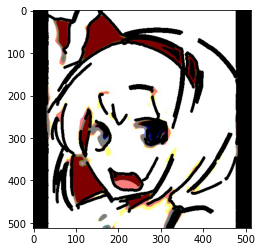

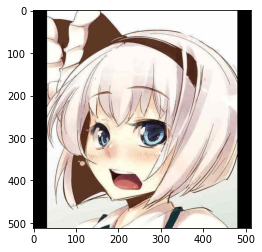

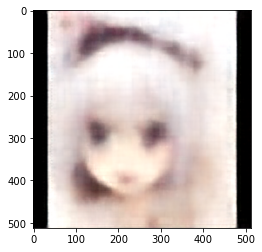

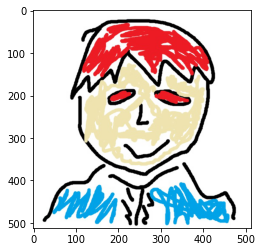

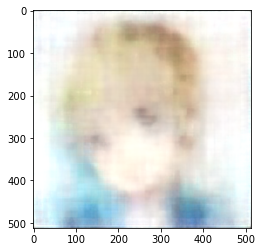

In [7]:
# visualization
index = 8

vae_model.eval()
input_img, target_img = data[index]
output_img = vae_model(input_img[None].to(device))['rec'][0].cpu().detach()


plt.figure()
plt.imshow(cv2.cvtColor(input_img.permute(1, 2, 0).numpy(), cv2.COLOR_BGR2RGB))

plt.figure()
plt.imshow(cv2.cvtColor(target_img.permute(1, 2, 0).numpy(), cv2.COLOR_BGR2RGB))

plt.figure()
plt.imshow(cv2.cvtColor(output_img.permute(1, 2, 0).numpy(), cv2.COLOR_BGR2RGB))

sketch = cv2.imread("./data/sketch.jpg") / 255
sketch_in = torch.tensor(sketch).float().permute(2, 0, 1)
sketch_out = vae_model(sketch_in[None].to(device))['rec'][0].cpu().detach()

plt.figure()
plt.imshow(cv2.cvtColor(sketch_in.permute(1, 2, 0).numpy(), cv2.COLOR_BGR2RGB))

plt.figure()
plt.imshow(cv2.cvtColor(sketch_out.permute(1, 2, 0).numpy(), cv2.COLOR_BGR2RGB))

In [150]:
torch.cuda.empty_cache()